In [1]:
%matplotlib notebook

import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6.0, 4.0)

import load_hats

start_day, end_day = '2016-06-01', '2018-05-31'
site = 'sum'

In [8]:
def read_met(site, yyyy):
    met_ftp = f'/aftp/met/{site}/'
    met_file = f'met_{site}_insitu_1_obop_hour_{yyyy}.txt'
    df = pd.read_csv(met_ftp+met_file, 
                delim_whitespace=True,
                names=['site','year','month','day','hour','wind_dir','wind_speed','wind_steady','press','temp2','temp10','jj','jk','jl'],
                parse_dates = {'date':[1,2,3,4]},
                infer_datetime_format=True,
                index_col='date',
                na_values=['-999.9', '-999', '-99', '-99.9']
                )
    df.drop(['temp2','temp10','jj','jk','jl'], axis=1, inplace=True)
    return df

<h1>Load NOAA met data

In [9]:
dfs = []
for y in [2016, 2017, 2018]:
    df = read_met(site, y)
    dfs.append(df)
    
met = pd.concat(dfs, axis=0)
met = met[start_day:end_day]

In [10]:
met.head()

,site,wind_dir,wind_speed,wind_steady,press
date,,,,,
2016-06-01 00:00:00,SUM,110.0,12.0,100,677.17
2016-06-01 01:00:00,SUM,118.0,13.9,100,676.52
2016-06-01 02:00:00,SUM,118.0,14.2,100,675.67
2016-06-01 03:00:00,SUM,119.0,14.8,100,675.16
2016-06-01 04:00:00,SUM,120.0,14.5,100,674.58


<h1>Load CATS data

In [5]:
cats = load_hats.CATS_FTP()
insitu = cats.hourly('f11', site)
insitu = insitu[start_day:end_day].dropna()
insitu.head()

,sum_mr,sum_sd
date,,
2016-06-01 01:21:00,230.654,1.013
2016-06-01 02:21:00,230.833,1.012
2016-06-01 03:21:00,231.293,1.015
2016-06-01 04:21:00,229.908,1.018
2016-06-01 05:21:00,230.252,1.018


<h2>Merge dataframes and interpolate wind speed and direction

In [11]:
full = pd.concat([insitu, met], axis=1)
full['wind_dir'] = full.wind_dir.interpolate()
full['wind_speed'] = full.wind_speed.interpolate()
full = full.drop(['site', 'wind_steady', 'press'], axis=1).dropna()
full.head()

,sum_mr,sum_sd,wind_dir,wind_speed
date,,,,
2016-06-01 01:21:00,230.654,1.013,118.0,14.05
2016-06-01 02:21:00,230.833,1.012,118.5,14.50
2016-06-01 03:21:00,231.293,1.015,119.5,14.65
2016-06-01 04:21:00,229.908,1.018,123.0,14.30
2016-06-01 05:21:00,230.252,1.018,129.0,14.00


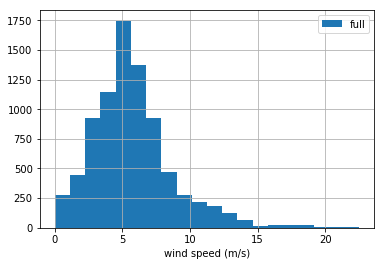

In [12]:
full.wind_speed.hist(bins=20, label='full')
plt.xlabel('wind speed (m/s)')
plt.legend()

<h3>Remove low wind speeds less than 3 m/s

In [24]:
clean = full.loc[full.wind_speed>3]
clean.shape

(6970, 4)

Text(0, 0.5, 'CFC-11 (ppt)')

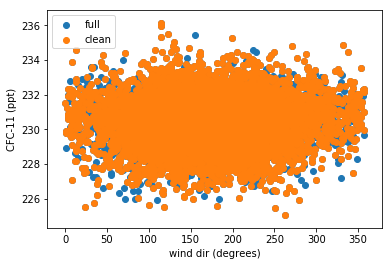

In [25]:
plt.scatter(full.wind_dir, full.sum_mr, label='full')
plt.scatter(clean.wind_dir, clean.sum_mr, label='clean')
plt.legend()
plt.xlabel('wind dir (degrees)')
plt.ylabel('CFC-11 (ppt)')

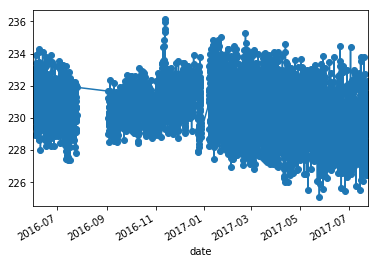

In [26]:
clean.sum_mr.plot(marker='o')

<h2>Subsample to once a day at 12-14 GMT    

In [27]:
clean.head()

,sum_mr,sum_sd,wind_dir,wind_speed
date,,,,
2016-06-01 01:21:00,230.654,1.013,118.0,14.05
2016-06-01 02:21:00,230.833,1.012,118.5,14.50
2016-06-01 03:21:00,231.293,1.015,119.5,14.65
2016-06-01 04:21:00,229.908,1.018,123.0,14.30
2016-06-01 05:21:00,230.252,1.018,129.0,14.00


In [28]:
clean = full.loc[full.wind_speed>3]
clean.reset_index(inplace=True)
# select hours
clean = clean.assign(hh=(clean.date.dt.hour==12)|(clean.date.dt.hour==13))
clean = clean.loc[clean.hh==True].drop(['hh'], axis=1)
# if two data points, select the first
clean = clean.assign(dd=clean.date.diff()>datetime.timedelta(0,4000))
clean = clean.loc[clean.dd==True].drop(['dd'], axis=1)
clean.set_index(clean.date, inplace=True)
clean.drop(['date'], axis=1, inplace=True)

In [29]:
clean.head()

,sum_mr,sum_sd,wind_dir,wind_speed
date,,,,
2016-06-02 12:24:00,231.812,1.026,175.5,8.80
2016-06-03 12:26:00,231.784,1.003,226.5,12.75
2016-06-04 12:28:00,231.775,0.943,269.5,5.40
2016-06-05 12:30:00,231.559,1.044,211.5,6.80
2016-06-07 12:34:00,229.924,1.134,233.5,3.20


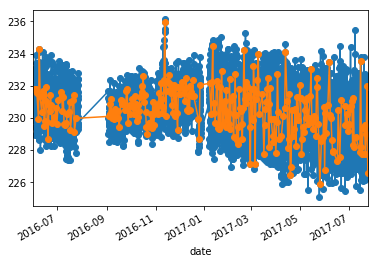

In [22]:
full.sum_mr.plot(marker='o')
clean.sum_mr.plot(marker='o')

In [30]:
print(f"Number of measurements full:{full.shape[0]} clean:{clean.shape[0]}")

Number of measurements full:8281 clean:307
